In [25]:
import os
import dask
from distributed import Client
import dask.dataframe as dd
import pandas as pd
import io
import requests
import base64
import binascii
import numpy as np
import dask.bag as db
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random


#c = Client('78.13.47.54:8001') #cluster di mattia
c = Client()
c

Client Scheduler: tcp://127.0.0.1:50534 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [26]:
def convert(mi):
    mat = np.zeros((mi.shape[0], 6), dtype = "u4")
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61
    return mat

def load_from_file(file): 
    m = np.fromfile(file, dtype = '<u8')
    mat = convert(m)
    return mat

In [27]:
url = 'https://cloud-areapd.pd.infn.it:5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/MAPD_miniDT_batch/'
data_names = requests.get(url, verify = False).text
data_names = data_names.split(sep = '\n')


data_names=data_names[:4] #subset of total data

#create dask bag
b = db.from_sequence(data_names).map(load_from_file).flatten()
#b.take(5)

/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cloud-areapd.pd.infn.it'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [28]:
initial_size=b.count().compute()
print("Initial number of elements:",initial_size)

Initial number of elements: 5242752


In [29]:
#filter head!=2 (STILL WITH DASK BAGS)
def head(x):
    if x[5]==2: return True
    
bag=b.filter(head)

#print new size
size_0=bag.count().compute()
print("Size 0: ",size_0," percentage wrt original shape: ",size_0*100/initial_size)

#bag.take(5)

Size 0:  4970184  percentage wrt original shape:  94.80105105105105


In [30]:
metadata=[('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), ('fpga', 'u1'), ('head', 'u1')]

#move to dask dataframe, WITH PERSIST (memory demanding)
df = bag.to_dataframe(meta = metadata).persist()

#print new size
size_1=df.shape[0].compute()
print("Size 1:",size_1,", percentage wrt original size:",size_1*100/initial_size)
df.head(10)

Size 1: 4970184 , percentage wrt original size: 94.80105105105105


,tdc,bx,orbit,chan,fpga,head
0,2,2922,3387200947,75,0,2
1,29,2227,3387200955,105,0,2
2,7,2234,3387200955,107,0,2
3,29,476,3387200973,126,0,2
4,12,1797,3387200955,55,1,2
5,28,2165,3387200956,36,1,2
6,14,249,3387200970,51,1,2
7,28,475,3387200973,90,1,2
8,16,485,3387200973,124,0,2
9,5,480,3387200973,127,0,2


Hits in the same Orbit: from 1 to 845


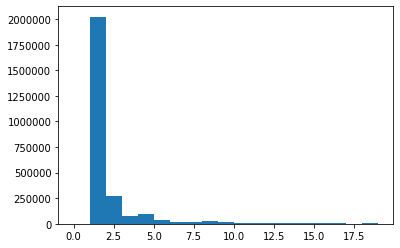

In [31]:
#counts number of hits per orbit
hits_per_orbit=df.groupby("orbit")["orbit"].count() 
min_hits=hits_per_orbit.min()
max_hits=hits_per_orbit.max()

print("Hits in the same Orbit: from "+str(min_hits.compute())+" to "+str(max_hits.compute()))
plt.hist(hits_per_orbit.compute(),bins=np.arange(0,20,1));
plt.show()

In [32]:
#select events with number of 3<hits_per_orbit<20
orbite=hits_per_orbit[(hits_per_orbit>3)&(hits_per_orbit<20)].index.compute() #series with orbits to keep
df1=df[df["orbit"].isin(orbite)].reset_index(drop=True)

size_2=df1.shape[0].compute()
print("Size 2:",size_2,", percentage wrt original size:",size_2*100/initial_size)

df1.head(10)

Size 2: 2038261 , percentage wrt original size: 38.87769247906443


,tdc,bx,orbit,chan,fpga,head
0,29,476,3387200973,126,0,2
1,28,475,3387200973,90,1,2
2,16,485,3387200973,124,0,2
3,5,480,3387200973,127,0,2
4,18,481,3387200973,42,1,2
5,6,480,3387200973,91,1,2
6,20,482,3387200973,45,1,2
7,21,489,3387200973,88,1,2
8,1,491,3387200973,138,1,2
9,19,485,3387200973,43,1,2


In [33]:
#select orbits that present a scintillator signal
orbits_with_scint=df1[df1["chan"]==128]["orbit"].unique().compute()

df2=df1[df1["orbit"].isin(orbits_with_scint)].reset_index(drop=True)

size_3=df2.shape[0].compute()
print("Size 3:",size_3,", percentage wrt original size",size_3*100/initial_size)

df2.head(10)

Size 3: 30497 , percentage wrt original size 0.5816983141678264


,tdc,bx,orbit,chan,fpga,head
0,27,878,1118948,91,1,2
1,8,882,1118948,107,0,2
2,18,881,1118948,47,1,2
3,12,884,1118948,88,1,2
4,7,881,1118948,128,1,2
5,14,881,1118948,44,1,2
6,17,883,1118948,90,1,2
7,1,891,1118948,138,1,2
8,5,887,1118948,46,1,2
9,12,889,1118948,89,1,2


In [34]:
#assign time information
df2=df2.assign(time=lambda x: 25*(x.bx + x.tdc/30)) #without orbit

#assign chamber values
df2["chamber"]=None

masks=[((df2["fpga"]==0)&(df2["chan"]//64==0)),
       ((df2["fpga"]==0)&(df2["chan"]//64==1)),
       ((df2["fpga"]==1)&(df2["chan"]//64==0)),
       ((df2["fpga"]==1)&(df2["chan"]//64==1))]

for i,mask in enumerate(masks):
    df2["chamber"]=df2["chamber"].mask(mask,i)
    
#add layer column
df2["layer"]=df2["chan"]%4

#add cell column
df2["cell"]=df2["chan"]%64

#drop unknown channels
df3=df2[df2.chan<=128]

#print updated size
size_4=df3.shape[0].compute()
print("Size 4:",size_4,", percentage wrt original size",size_4*100/initial_size)


df3.head(10)

Size 4: 29462 , percentage wrt original size 0.5619567738470177


,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell
0,27,878,1118948,91,1,2,21972.500000,3,3,27
1,8,882,1118948,107,0,2,22056.666667,1,3,43
2,18,881,1118948,47,1,2,22040.000000,2,3,47
3,12,884,1118948,88,1,2,22110.000000,3,0,24
4,7,881,1118948,128,1,2,22030.833333,None,0,0
5,14,881,1118948,44,1,2,22036.666667,2,0,44
6,17,883,1118948,90,1,2,22089.166667,3,2,26
8,5,887,1118948,46,1,2,22179.166667,2,2,46
9,12,889,1118948,89,1,2,22235.000000,3,1,25
10,20,890,1118948,105,0,2,22266.666667,1,1,41


In [39]:
#filter orbits with multiple scintillator activations
def multiple_scint(group):
    if group[group.chan==128].shape[0]>1: return None
    else: return group
    
metadata=[('tdc', 'u1'),('bx', 'u2'),('orbit', 'u4'),('chan', 'u2'),('fpga', 'u1'),('head', 'u1'),
         ('time','u2'),('chamber','u1'),('layer','u1'),('cell','u2')]

df4=df3.groupby("orbit").apply(multiple_scint,meta=metadata).reset_index(drop=True)


#print updated size
size_5=df4.shape[0].compute()
print("Size 5:",size_5,", percentage wrt original size",size_5*100/initial_size)

df4.head(10)

Size 5: 29317 , percentage wrt original size 0.5591910508069045


,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell
0,27,878,1118948,91,1,2,21972.500000,3,3,27
1,8,882,1118948,107,0,2,22056.666667,1,3,43
2,18,881,1118948,47,1,2,22040.000000,2,3,47
3,12,884,1118948,88,1,2,22110.000000,3,0,24
4,7,881,1118948,128,1,2,22030.833333,None,0,0
5,14,881,1118948,44,1,2,22036.666667,2,0,44
6,17,883,1118948,90,1,2,22089.166667,3,2,26
7,5,887,1118948,46,1,2,22179.166667,2,2,46
8,12,889,1118948,89,1,2,22235.000000,3,1,25
9,20,890,1118948,105,0,2,22266.666667,1,1,41


In [40]:
metadata=[('tdc', 'u1'),('bx', 'u2'),('orbit', 'u4'),('chan', 'u2'),('fpga', 'u1'),('head', 'u1'),
         ('time','u2'),('chamber','u1'),('layer','u1'),('cell','u1'),('t0','u2')]

#add scintillator information
def t0(group):
    length=group.shape[0]
    scint=group[group["chan"]==128].time.values
    group=group.assign(t0=np.repeat(a=scint,repeats=length))
    return group

df5=df4.groupby("orbit").apply(t0,meta=metadata).reset_index(drop=True).persist() #with PERSIST to imrpove following computation time
df5.head(10)

,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell,t0
0,27,878,1118948,91,1,2,21972.500000,3,3,27,22030.833333
1,8,882,1118948,107,0,2,22056.666667,1,3,43,22030.833333
2,18,881,1118948,47,1,2,22040.000000,2,3,47,22030.833333
3,12,884,1118948,88,1,2,22110.000000,3,0,24,22030.833333
4,7,881,1118948,128,1,2,22030.833333,None,0,0,22030.833333
5,14,881,1118948,44,1,2,22036.666667,2,0,44,22030.833333
6,17,883,1118948,90,1,2,22089.166667,3,2,26,22030.833333
7,5,887,1118948,46,1,2,22179.166667,2,2,46,22030.833333
8,12,889,1118948,89,1,2,22235.000000,3,1,25,22030.833333
9,20,890,1118948,105,0,2,22266.666667,1,1,41,22030.833333


In [80]:
# scintillator time offset by Chamber
time_offset_by_chamber = { 0: 95.0 - 1.1, 1: 95.0 + 6.4, 2: 95.0 + 0.5, 3: 95.0 - 2.6}

#add time offsets by chamber
for key in time_offset_by_chamber.keys():
    mask=(df5["chamber"]==key)
    df5["t0"]=df5["t0"].mask(mask,df5["t0"] + time_offset_by_chamber[key])

df5.head(12)


,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell,t0
0,27,878,1118948,91,1,2,21972.500000,3,3,27,22215.633333
1,8,882,1118948,107,0,2,22056.666667,1,3,43,22233.633333
2,18,881,1118948,47,1,2,22040.000000,2,3,47,22221.833333
3,12,884,1118948,88,1,2,22110.000000,3,0,24,22215.633333
4,7,881,1118948,128,1,2,22030.833333,None,0,0,22030.833333
5,14,881,1118948,44,1,2,22036.666667,2,0,44,22221.833333
6,17,883,1118948,90,1,2,22089.166667,3,2,26,22215.633333
7,5,887,1118948,46,1,2,22179.166667,2,2,46,22221.833333
8,12,889,1118948,89,1,2,22235.000000,3,1,25,22215.633333
9,20,890,1118948,105,0,2,22266.666667,1,1,41,22233.633333


In [101]:
#drop events with multiple hits on the same layer
def multiple_layers(group):
    
    #obtain all ordered (chamber,layer) pairs
    pairs=pd.Series([(a,b) for a,b in zip(group["chamber"],group["layer"])]) #might be slow
    
    if pairs.duplicated().any(): return None
    else: return group

df6=df5.groupby("orbit").apply(multiple_layers,meta=metadata).reset_index(drop=True)

#print updated size
size_6=df6.shape[0].compute()
print("Size 6:",size_6,", percentage wrt original size",size_6*100/initial_size)

df6.head(10)

Size 5: 16944 , percentage wrt original size 0.3231890427012378


,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell,t0
0,27,878,1118948,91,1,2,21972.500000,3,3,27,22215.633333
1,8,882,1118948,107,0,2,22056.666667,1,3,43,22233.633333
2,18,881,1118948,47,1,2,22040.000000,2,3,47,22221.833333
3,12,884,1118948,88,1,2,22110.000000,3,0,24,22215.633333
4,7,881,1118948,128,1,2,22030.833333,None,0,0,22030.833333
5,14,881,1118948,44,1,2,22036.666667,2,0,44,22221.833333
6,17,883,1118948,90,1,2,22089.166667,3,2,26,22215.633333
7,5,887,1118948,46,1,2,22179.166667,2,2,46,22221.833333
8,12,889,1118948,89,1,2,22235.000000,3,1,25,22215.633333
9,20,890,1118948,105,0,2,22266.666667,1,1,41,22233.633333


In [102]:
#SELECT PROPER CHAMBERS (useless)
def chambers(group):
    
    uniques=group.chamber.unique()
    uniques=np.sort(uniques[uniques!=None])

    if np.all(uniques==[0,2,3]): return group
    else: return None
    
df7=df6.groupby("orbit").apply(chambers,meta=metadata).reset_index(drop=True)

if len(df7)==0: print("The dataframe is empty!")


The dataframe is empty!


In [103]:
#convert to pandas dataframe
data=df6.reset_index(drop=True).compute()

#reset index
data=data.reset_index(drop=True)
data

,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell,t0
0,27.0,878.0,1118948.0,91.0,1.0,2.0,21972.500000,3,3.0,27.0,22215.633333
1,8.0,882.0,1118948.0,107.0,0.0,2.0,22056.666667,1,3.0,43.0,22233.633333
2,18.0,881.0,1118948.0,47.0,1.0,2.0,22040.000000,2,3.0,47.0,22221.833333
3,12.0,884.0,1118948.0,88.0,1.0,2.0,22110.000000,3,0.0,24.0,22215.633333
4,7.0,881.0,1118948.0,128.0,1.0,2.0,22030.833333,None,0.0,0.0,22030.833333
...,...,...,...,...,...,...,...,...,...,...,...
16939,18.0,3371.0,19731346.0,120.0,0.0,2.0,84290.000000,1,0.0,56.0,84308.633333
16940,7.0,3369.0,19731346.0,39.0,1.0,2.0,84230.833333,2,3.0,39.0,84296.833333
16941,4.0,3370.0,19731346.0,41.0,1.0,2.0,84253.333333,2,1.0,41.0,84296.833333
16942,13.0,3374.0,19731346.0,40.0,1.0,2.0,84360.833333,2,0.0,40.0,84296.833333


In [104]:
#function to calculate coordinates of centres of cells
def centres(ev):
    
    dx=1
    dy=1/2
    gap=4
    
    x = np.zeros(ev.shape[0])
    y = np.zeros(ev.shape[0])
    
    #calculate coordinates of centers
    for i in range(ev.shape[0]): 
        
        layer = ev.loc[i,'layer']
        cell = ev.loc[i,'cell']
        chamber = ev.loc[i,'chamber']

        if layer == 0 : 
            x[i] = cell/4
            y[i] = dy/2 +chamber*gap 
        
        elif layer == 2 :
            x[i] = (cell-2)/4 + dx/2
            y[i] = dy/2 + dy + chamber*gap
        
        elif layer == 1 :
            x[i] = (cell-1)/4
            y[i] = dy/2 + 2*dy + chamber*gap
        
        elif layer == 3 : 
            x[i] = (cell-3)/4 + dx/2
            y[i] = dy/2+3*dy + chamber*gap
        
            
    return [x,y]

In [105]:
#function to draw the activated cells
def boxes(ax,x,y):
    
    dx = 1
    dy = 1/2
     
    for i in range(len(x)) :
        rect = patches.Rectangle((x[i]-dx/2,y[i]-dy/2),dx,dy,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)



In [106]:
#function to draw the detector
def draw_detector(ax) :
    
    dx = 1
    dy = 1/2
    gap=4

    #adjust
    ax.set_xlim(0,16.5)
    ax.set_ylim(-0.2,15.2)

    #coordinates of layer 0
    x_1 = np.arange(1,16)-dx/2
    y_1 = 0
    
    #coordinates of layer 2
    x_2 = x_1 + dx/2
    y_2 = dy
    
    #coordinates of layer 3
    x_3 = x_1 
    y_3 = 2*dy
    
    #coordinates of layer 4
    x_4 = x_2
    y_4 = 3*dy
    
    for j in range(4):
        
        for i in range(15): 
            rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            ax.axis('off')
        
        #increment y chamber
        y_1+=gap
        y_2+=gap
        y_3+=gap
        y_4+=gap

In [107]:
events=[value for value in data.groupby(["orbit"]).groups.values()]
event=[data.loc[events[i]]  for i in np.random.randint(low=0,high=len(events),size=6)] #select 6 random events to show
event[0]

,tdc,bx,orbit,chan,fpga,head,time,chamber,layer,cell,t0
10770,10.0,442.0,3371031.0,45.0,1.0,2.0,11058.333333,2,1.0,45.0,11234.333333
10771,24.0,438.0,3371031.0,89.0,1.0,2.0,10970.000000,3,1.0,25.0,11228.133333
10772,22.0,441.0,3371031.0,128.0,1.0,2.0,11043.333333,None,0.0,0.0,11043.333333
10773,15.0,447.0,3371031.0,44.0,1.0,2.0,11187.500000,2,0.0,44.0,11234.333333
10774,30.0,442.0,3371031.0,88.0,1.0,2.0,11075.000000,3,0.0,24.0,11228.133333
10775,14.0,447.0,3371031.0,42.0,1.0,2.0,11186.666667,2,2.0,42.0,11234.333333
10776,12.0,451.0,3371031.0,86.0,1.0,2.0,11285.000000,3,2.0,22.0,11228.133333
10777,5.0,443.0,3371031.0,107.0,0.0,2.0,11079.166667,1,3.0,43.0,11246.133333
10778,27.0,444.0,3371031.0,104.0,0.0,2.0,11122.500000,1,0.0,40.0,11246.133333
10779,27.0,448.0,3371031.0,62.0,0.0,2.0,11222.500000,0,2.0,62.0,11231.133333


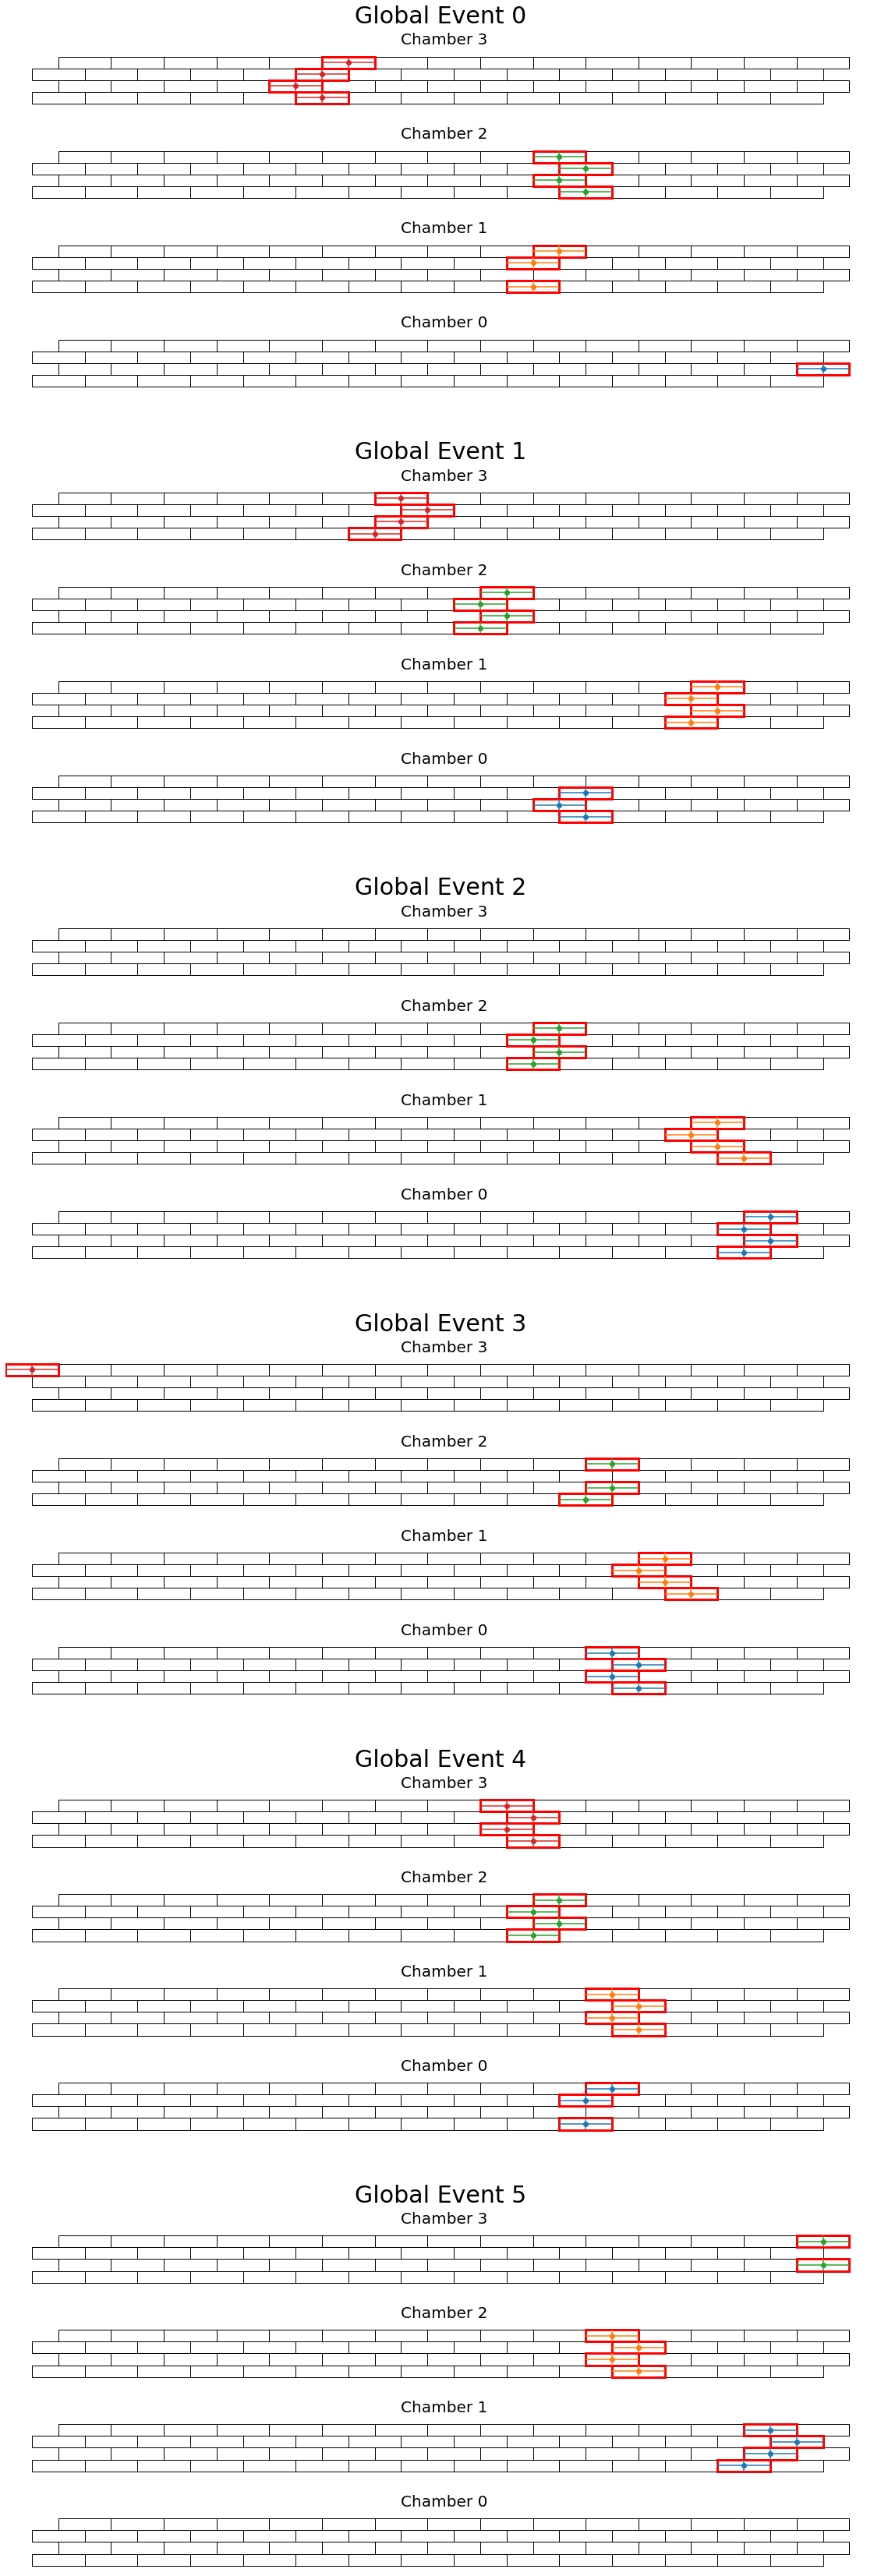

In [108]:
fig,ax = plt.subplots(nrows=len(event),ncols=1,figsize=(20,60))

#draw selected events
for i,ev in enumerate(event):

    global_event=ev[ev["chan"]<=128].sort_values(by="chamber").reset_index(drop=True)
    local=global_event.groupby("chamber")
    local_events=[local.get_group(x) for x in local.groups]

    #draw events
    dx = 1
    dy = 1/2
    gap=4

    ax[i].set_title("Global Event %d" %i,fontsize=30)
    draw_detector(ax[i])

    for j in range(len(local_events)):

        single=local_events[j].reset_index(drop=True)#.drop(["level_0","index"],axis=1)
        boxes(ax[i],centres(single)[0],centres(single)[1])
        ax[i].errorbar(*centres(single),dy/2,dx/2,fmt='o')

    ax[i].text(x=7.5,y=5*dy+3*gap,s="Chamber 3",fontsize=20)
    ax[i].text(x=7.5,y=5*dy+2*gap,s="Chamber 2",fontsize=20)
    ax[i].text(x=7.5,y=5*dy+gap,s="Chamber 1",fontsize=20)
    ax[i].text(x=7.5,y=5*dy,s="Chamber 0",fontsize=20)

plt.show()


In [24]:
c.close()